<a href="https://colab.research.google.com/github/i1idan/schizophrenia-diagnosis-eeg-signals/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Clone the Repository

In [ ]:
!git clone https://github.com/i1idan/schizophrenia-diagnosis-eeg-signals.git

In [ ]:
import os
os.chdir('/content/schizophrenia-diagnosis-eeg-signals')
!git pull origin main

# Install Requirements

In [ ]:
!pip install -r requirements.txt

# Get Data

In [ ]:
!gdown --id 1jnWHWrArzJQIvny0cQkfPP42hEJAp_56
!mv DATA.mat /content/schizophrenia-diagnosis-eeg-signals/data/DATA.mat

# Training Models

In [2]:
import os
import warnings
from train import main
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
# Number of training in a sequence
multi_train = 10
epochs = 200
model_names = ["WaveletCustom", "FFTCustom", "Transformer", "conv_lstm"]
data_path = "./data/DATA.mat"
# checkpoints = "/content/drive/MyDrive/schizophrenia/checkpoints"
checkpoints = "./checkpoints"
batch_size = 4
early_stopping = 100
reduce_lr = 50
seed = 1234

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# suppress warnings:
warnings.filterwarnings("ignore")

for model_name in model_names:
    for n in range(multi_train):
        dir_name = f"{n}"
        new_seed = seed + n
        # preserve reproducibility
        #     !PYTHONHASHSEED=0
        #     !TF_DETERMINISTIC_OPS=0
        #     !TF_CUDNN_DETERMINISTIC=0
        main(model_name=model_name, epochs=epochs, seed=new_seed,
             dir_name=dir_name, checkpoints=checkpoints, batch_size=batch_size)
        print(f"-----------------------------train {n} is done! ----------------------------------")

# Get Metrics

In [12]:
from utils.group_metrics import get_mean_std
import os
for model_name in model_names:
    print(f"[INFO] Processing Model: {model_name}")
    csv_files = [os.path.join(checkpoints, model_name ,f"{n}", "log.csv") for n in range(multi_train)]
    metrics = get_mean_std(csv_files, 
                       arguments=("accuracy", "loss", "val_accuracy", "val_loss"),
                      )
    print(model_name, "\n", metrics)

[INFO] Processing Model: WaveletCustom
[INFO] Extracting values from csv files...
[INFO] Getting the values of file ./checkpoints\WaveletCustom\0\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\1\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\2\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\3\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\4\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\5\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\6\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\7\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\8\log.csv
[INFO] Getting the values of file ./checkpoints\WaveletCustom\9\log.csv
WaveletCustom 
 {'accuracy': {'std': 0.076, 'mean': 0.8386}, 'loss': {'std': 0.143, 'mean': 0.3481}, 'val_accuracy': {'std': 0.0616, 'mean': 0.7729}, 'val_loss': {'std': 0.0819, 'mean': 0.4769}}
[IN

# Get Sensitivity & Specificity

In [5]:
from utils.group_metrics import get_conf_mean_std
import os
for model_name in model_names:
    print(f"[INFO] Processing {model_name}")
    conf_matrixes = [os.path.join(checkpoints, model_name ,f"{n}", "conf_matrix.csv") for n in range(multi_train)]

    metrics = get_conf_mean_std(conf_matrixes)
    print(model_name, "\n", metrics)

[INFO] Processing WaveletCustom
[INFO] Extracting values from confusion matrices
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\0\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\1\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\2\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\3\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\4\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\5\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\6\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\7\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\8\conf_matrix.csv
[INFO] Getting the values of df: ./checkpoints\WaveletCustom\9\conf_matrix.csv
[INFO] Successfully Extracted dict_keys(['sensitivity', 'specificity', 'accuracy', 'f1_score'])
WaveletCustom 
 {'sensitivity': {

C:\Users\pooya\projects\schizophrenia-diagnosis-eeg-signals\utils\group_metrics.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
  specificity = tn / (tn + fp)


In [6]:
from delong_test import delong_test_fn
output_z = np.zeros((len(model_names), len(model_names)))
output_p = np.zeros((len(model_names), len(model_names)))
train_n = 0
for f_e, f in enumerate(model_names):
    for s_e, s in enumerate(model_names):
        df1 = pd.read_csv(os.path.join(checkpoints, f , f"{train_n}", "y_test_pred.csv"))
        df2 = pd.read_csv(os.path.join(checkpoints, s , f"{train_n}", "y_test_pred.csv"))
        assert np.all(df1['y_test'].values == df2['y_test'].values)
        z, p = delong_test_fn(df1['y_test'].values, df1['y_pred'].values, df2['y_pred'].values)
        output_p[f_e, s_e] = p
        output_z[f_e, s_e] = z

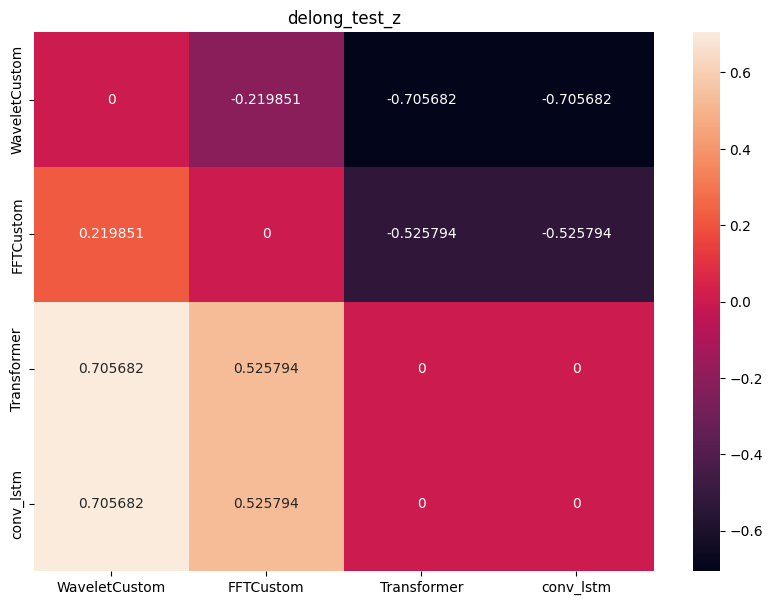

In [7]:
df_cm = pd.DataFrame(output_z, index=model_names, columns=model_names)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("delong_test_z")
plt.xlabel("")
plt.ylabel("")
plt.savefig('delong_test_z.png')
plt.show()

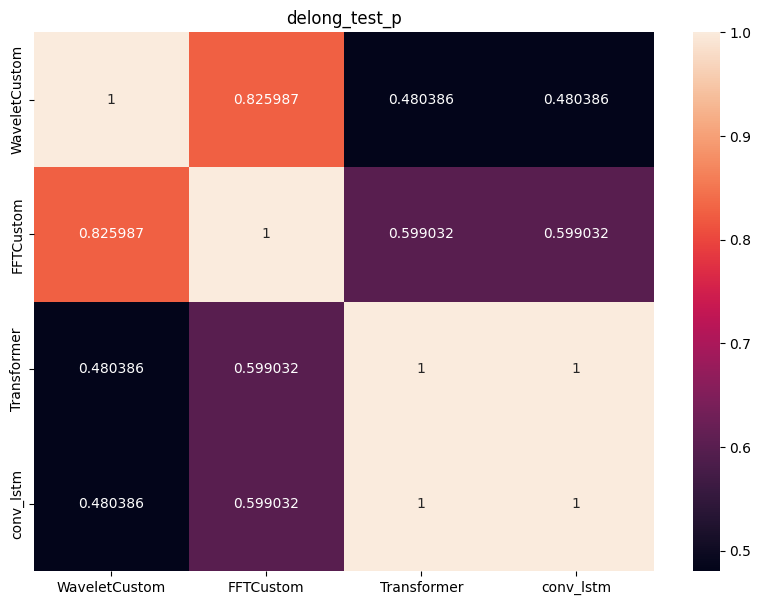

In [8]:
df_cm = pd.DataFrame(output_p, index=model_names, columns=model_names)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("delong_test_p")
plt.xlabel("")
plt.ylabel("")
plt.savefig('delong_test_p.png')
plt.show()

In [6]:
model_best_path

'./checkpoints\\WaveletCustom\\0\\model_best'

In [7]:
import os
import shutil

multi_train = 10
model_names = ["WaveletCustom", "FFTCustom", "Transformer", "conv_lstm"]
checkpoint_model_path = "./checkpoint_model_path"
checkpoints = "./checkpoints"
os.makedirs(checkpoint_model_path, exist_ok=True)
for model_name in model_names:
    for n in range(multi_train):
        dir_path = os.path.join(checkpoint_model_path, model_name ,f"{n}")
        os.makedirs(dir_path, exist_ok=True)
        model_best_path = os.path.join(checkpoints, model_name ,f"{n}", "model_best")
        shutil.move(model_best_path, dir_path)
        
            

_:)_